In [6]:
import os
import sys
import math
from liblibra_core import * 
from libra_py import *
import numpy as np
import cProfile, pstats, io
import matplotlib.pyplot as plt
from scipy.special import gamma

In [35]:
def gaussian_kernel(Q, dim, b, ComputePotential = True):
    """
    Args:
        Q ( MATRIX(ndof, ntraj) ): coordinates of all worlds in the ndof-dimensional phase space
        dim ( int ): physical dimensionalty of each world
        b ( float ): parameter
           
    Note:
       ndof = npart * dim, where npart = the number of particles, dim - dimensionality of the problem
              we usually don't care about npart, although we care about dim
       ntraj = the number of worlds
       
    Returns:
        F: MATRIX(ndof, ntraj) containing MIW forces felt by Q.
        MIW_Potential: Scalara MIW Potential.
    """
    
    ndof = Q.num_of_rows
    ntraj = Q.num_of_cols
    ntraj2 = ntraj * ntraj
    b2 = b*b
    frc = (2.0/b2)
    nrm = 1.0 / (ntraj * math.pow( math.sqrt(math.pi) * b, dim) )

    # The rho/P notation is confusing to me as it supresses the order of the object,
    # and the order doesn't correspond to whether it's summed over j or not.

    # I've left the rho(P) notation for the ones that aren't(are) summed over j
    # but I've also added suffix_#numberOfIndices to the objects
    # where it is not obvious.
    
    # 1 index
    P_1 = MATRIX(ntraj, 1)
    
    # 2 index
    r2 = MATRIX(ntraj, ntraj) #probably delete later
    gik = MATRIX(ndof, ntraj)
    F = MATRIX(ndof, ntraj)
    
    #Pij[i][j] => rho_2.get(i, j)
    rho_2 = MATRIX(ntraj, ntraj)
    #dPik[i][k] => dP_2.get(k, i)
    dP_2 = MATRIX(ndof, ntraj)
    #ddPik[i][k]
    d2P_2 = MATRIX(ndof, ntraj)
    
    # 3 index
    
    #dPijk[i][j][k] => drho_3.get(k, i*ntraj + j)
    drho_3 = MATRIX(ndof, ntraj2)
    
    #ddPijk[i][j][k] => d2rho_3.get(k, i*ntraj + j)
    d2rho_3 = MATRIX(ndof, ntraj2)

    # Compute rho, 
    for i in range(ntraj):
        pi = 0.0
        for j in range(ntraj):
            
            #COMPUTE r^2_ij = r2
            # Don't think this is actually ever used/neededd
            rij2 = 0.0
            for idof in range(ndof):
                dq = Q.get(idof, i) - Q.get(idof, j)
                rij2 += dq**2
            
            # EQ A1 top Row
            r2.set(i, j, rij2)  
            
            #COMPUTE Pij=rho_2
            pij = nrm * math.exp(-rij2/b2)
            #pij = nrm * math.exp(-r2.get(i, j)/b2)
            
            # EQ A1 middle row
            rho_2.set(i, j, pij)
            
            indx = i * ntraj + j
            for idof in range(ndof):
                #r_{ij}^k = dq
                dq = Q.get(idof, i) - Q.get(idof, j)
                
                #EQ A1 bottom row Left Side
                drho_3.set(idof, indx, -frc*dq*pij) 
                
                #EQ A1 bottom row Right Side (3 index version)
                d2rho_3.set(idof, indx, -frc*( 1 - frc * dq*dq)*pij)
                

            #INCREMENT term to be summed over j.
            pi += pij
            if j == range(ntraj)[-1]:
                #COMPUTE Pi = P_1
                P_1.set(i, 1, pi)
                
    MIW_Potential = 0
    for i in range(ntraj):
        for idof in range(ndof):
            dpik = 0.0
            d2pik = 0.0
            for j in range(ntraj):
                #Summing over j the terms in bottom row of EQ A1
                dpik += drho_3.get(idof, i*ntraj + j)
                d2pik += d2rho_3.get(idof, i*ntraj + j)
            #EQ A1 Bottom row Left Side (summed over j)
            dP_2.set(idof, i, dpik)
            
            #EQ A1 Bottom row Right Side
            #Slight correction is that this term is P_i^{k''}
            d2P_2.set(idof, i, d2pik)
            
            #EQ A5 Left 
            curr_gik = .5 * dP_2.get(idof, i)/P_1.get(i, 1) 
            gik.set(idof, i,  curr_gik)
            
            #+++ (m=1 hardcoded here in EQ A5)
            MIW_Potential += .5 * curr_gik**2
            
    #Compute Forces (dU / dx_n^L) n->traj, L->dof 
    for n in range(ntraj):
        for L in range(ndof):
            Fres = 0
            
            #A6 Line 1
            Fres += 2.0*gik.get(L, n) * ( -1.0/(P_1.get(n, 1)**2) * dP_2.get(L, n)**2 \
                                     + 1.0/P_1.get(n, 1) * d2P_2.get(L, n) )
            #A6 Line 2
            for i in range(ntraj):
                if i != n:
                    Fres += 2.0*gik.get(L, i) * ( 1.0/(P_1.get(i, 1)**2) * drho_3.get(L, i*ntraj + n) * dP_2.get(L, i) \
                                               -  1.0/P_1.get(i, 1) * d2rho_3.get(L, i*ntraj + n) )
            #A6 Line 3
            for k in range(ndof):
                if k != L:
                    res = 0
                    for j in range(ntraj):
                        res += ( Q.get(k, n) - Q.get(k, j) ) * drho_3.get(L, n*ntraj + j)
                    
                    Fres += 2.0*gik.get(k, n) * ( -1.0/(P_1.get(n, 1)**2) * dP_2.get(k, n) * dP_2.get(L, n) \
                                               - frc/P_1.get(n, 1) * res )
            #A6 Line 4
            for i in range(ntraj):
                if i != n:
                    for k in range(ndof):
                        if k != L:
                            Fres += 2.0*gik.get(k, i) * ( 1/(P_1.get(i, 1)**2) * drho_3.get(k, i*ntraj, n) * dP_2.get(L, i) \
                                                         + frc/P_1.get(i, 1) * ( Q.get(k, i) - Q.get(k, n) ) * drho_3.get(L, i*ntraj + n) )
            
            # Update with -dU/dx_n^L
            F.set(L, n, -Fres)
            
        # End L
    #End n
    if ComputePotential:
        return(F, MIW_Potential)
    else:
        return(F)
    
    
def exponential_kernel(Q, dim, b, ComputePotential = True):
    """
    Args:
        Q ( MATRIX(ndof, ntraj) ): coordinates of all worlds in the ndof-dimensional phase space
        dim ( int ): physical dimensionalty of each world
        b ( float ): parameter
           
    Note:
       ndof = npart * dim, where npart = the number of particles, dim - dimensionality of the problem
              we usually don't care about npart, although we care about dim
       ntraj = the number of worlds
       
    Returns:
        F: MATRIX(ndof, ntraj) containing MIW forces felt by Q.
        MIW_Potential: Scalara MIW Potential.
    """
    
    ndof = Q.num_of_rows
    ntraj = Q.num_of_cols
    ntraj2 = ntraj * ntraj
    b2 = b*b
    frc = (2.0/b2)
    nrm = gamma(dim/2) / ( 2*ntraj * math.factorial(dim-1) * math.pow( math.sqrt(math.pi)*b, dim ) ) 

    # The rho/P notation is confusing to me as it supresses the order of the object,
    # and the order doesn't correspond to whether it's summed over j or not.

    # I've left the rho(P) notation for the ones that aren't(are) summed over j
    # but I've also added suffix_#numberOfIndices to the objects
    # where it is not obvious.
    
    # 1 index
    P_1 = MATRIX(ntraj, 1)
    
    # 2 index
    r = MATRIX(ntraj, ntraj) # r.get(i, j) = \sqrt{\sum_k (r_{ij}^k)^2
    gik = MATRIX(ndof, ntraj)
    F = MATRIX(ndof, ntraj)
    
    #Pij[i][j] => rho_2.get(i, j)
    rho_2 = MATRIX(ntraj, ntraj)
    #dPik[i][k] => dP_2.get(k, i)
    dP_2 = MATRIX(ndof, ntraj)
    #ddPik[i][k]
    d2P_2 = MATRIX(ndof, ntraj)
    
    # 3 index
    
    #dPijk[i][j][k] => drho_3.get(k, i*ntraj + j)
    drho_3 = MATRIX(ndof, ntraj2)
    
    #ddPijk[i][j][k] => d2rho_3.get(k, i*ntraj + j)
    d2rho_3 = MATRIX(ndof, ntraj2)

    # Compute rho, 
    for i in range(ntraj):
        pi = 0.0
        for j in range(ntraj):
            
            #COMPUTE r^2_ij = r2
            # Don't think this is actually ever used/neededd
            rij = 0.0
            for idof in range(ndof):
                dq = Q.get(idof, i) - Q.get(idof, j)
                rij += dq**2
            rij = math.sqrt(rij)
            
            # EQ A1 top Row
            r.set(i, j, rij)  
            
            #COMPUTE Pij=rho_2
            pij = nrm * math.exp(-rij/b)
            #pij = nrm * math.exp(-r2.get(i, j)/b2)
            
            # EQ A1 middle row
            rho_2.set(i, j, pij)
            
            indx = i * ntraj + j
            for idof in range(ndof):
                #r_{ij}^k = dq
                dq = Q.get(idof, i) - Q.get(idof, j)
                
                #EQ A1 bottom row Left Side
                # need i !=j else 1/rij factors -> undefined
                if i != j:
                    drho_3.set(idof, indx, -1.0/b * dq/rij * pij) 
                
                    #EQ A1 bottom row Right Side (3 index version)
                    d2rho_3.set(idof, indx, -1.0/(b * rij) * ( 1.0 - (dq*dq)/(rij*rij) \
                                                             - 1.0/b * (dq*dq)/(rij) ) * pij)
                

            #INCREMENT term to be summed over j.
            pi += pij
            if j == range(ntraj)[-1]:
                #COMPUTE Pi = P_1
                P_1.set(i, 1, pi)
                
    MIW_Potential = 0
    for i in range(ntraj):
        for idof in range(ndof):
            dpik = 0.0
            d2pik = 0.0
            for j in range(ntraj):
                #Summing over j the terms in bottom row of EQ A1
                dpik += drho_3.get(idof, i*ntraj + j)
                d2pik += d2rho_3.get(idof, i*ntraj + j)
                                
            #EQ A1 Bottom row Left Side (summed over j)
            dP_2.set(idof, i, dpik)
            
            #EQ A1 Bottom row Right Side
            #Slight correction is that this term is P_i^{k''}
            d2P_2.set(idof, i, d2pik)
            
            #EQ A5 Left 
            curr_gik = .5 * dP_2.get(idof, i)/P_1.get(i, 1) 
            gik.set(idof, i,  curr_gik)
            
            #+++ (m=1 hardcoded here in EQ A5)
            MIW_Potential += .5 * curr_gik**2
            
    #Compute Forces (dU / dx_n^L) n->traj, L->dof 
    for n in range(ntraj):
        for L in range(ndof):
            Fres = 0
            
            #A6 Line 1
            Fres += 2.0*gik.get(L, n) * ( -1.0/(P_1.get(n, 1)**2) * dP_2.get(L, n)**2 \
                                     + 1.0/P_1.get(n, 1) * d2P_2.get(L, n) )
            #A6 Line 2
            for i in range(ntraj):
                if i != n:
                    Fres += 2.0*gik.get(L, i) * ( 1.0/(P_1.get(i, 1)**2) * drho_3.get(L, i*ntraj + n) * dP_2.get(L, i) \
                                               -  1.0/P_1.get(i, 1) * d2rho_3.get(L, i*ntraj + n) )
            #A6 Line 3
            for k in range(ndof):
                if k != L:
                    res = 0
                    for j in range(ntraj):
                        if j != n:
                            res += ( Q.get(k, n) - Q.get(k, j) ) / r.get(n, j) * ( 1.0/r.get(n, j) + 1.0/b ) * drho_3.get(L, n*ntraj + j) 
                    
                    Fres += 2.0*gik.get(k, n) * ( -1.0/(P_1.get(n, 1)**2) * dP_2.get(k, n) * dP_2.get(L, n) \
                                               - 1.0/P_1.get(n, 1)* res )
            #A6 Line 4
            for i in range(ntraj):
                if i != n:
                    for k in range(ndof):
                        if k != L:
                            Fres += 2.0*gik.get(k, i) * ( 1.0/(P_1.get(i, 1)**2) * drho_3.get(k, i*ntraj, n) * dP_2.get(L, i) \
                                                         + 1.0/P_1.get(i, 1) * (Q.get(k, i) - Q.get(k, n)) / r.get(i, n) * (1.0/r.get(i, n) + 1.0/b) * drho_3.get(L, i*ntraj + n) )
            
            # Update with -dU/dx_n^L
            F.set(L, n, -Fres)
            
        # End L
    #End n
    if ComputePotential:
        return(F, MIW_Potential)
    else:
        return(F)


# Can delete this later, like to be able to swap back and forth for slicing/modifications/printing though for now.
def ConvertMatrix(A):
    #Converts either Libra->numpy or numpy -> Libra, numpy shape obviously must be (X, Y)
    try:
        ndof = A.shape[0]
        ntraj = A.shape[1]
        Alibra = MATRIX(ndof, ntraj)

        for i in range(ndof):
            for j in range(ntraj):
                Alibra.set(i, j, A[i][j])
        return(Alibra)
    
    except:
        ndof = A.num_of_rows
        ntraj = A.num_of_cols
        Anp = np.zeros((ndof, ntraj))
        for i in range(ndof):
            for j in range(ntraj):
                Anp[i][j] = A.get(i, j)
        return(Anp)
    
#+++ Whole function needs to be modified for M!=1
def Verlet(X, b, steps, dt, filename = "Default.xyz"):
    ndof = X.num_of_rows
    ntraj = X.num_of_cols
    V = MATRIX(ndof, ntraj)
    F, U = gaussian_kernel(X, 1, b)
    
    T = np.zeros( len(range(steps)) )
    MIW = np.zeros( len(range(steps)) )
    
    for i in range(steps):    
        WriteToXYZ(X, filename)
        Tres = 0
        for dof in range(ndof):
            for traj in range(ntraj):
                
                #Kinetics for each dof before updates.
                Tres += V.get(dof, traj)**2 * .5
                
                V.set(dof, traj, V.get(dof, traj) + .5 * F.get(dof, traj) * dt )
                X.set(dof, traj, X.get(dof, traj) + V.get(dof, traj) *dt)
                
        #Update MIW Potential before any updates
        MIW[i] = U
        #Update 
        T[i] = Tres
        F, U = gaussian_kernel(X, 1, b)
        for dof in range(ndof):
            for traj in range(ntraj):
                V.set(dof, traj, V.get(dof, traj) + .5 * F.get(dof, traj) * dt)
            
            #endTraj
        #endDoF

    #endSteps
    return(MIW, T)
                
def WriteToXYZ(X, filename):
    ndof = X.num_of_rows
    ntraj = X.num_of_cols
    f = open(filename, "a+")
    if ndof == 1:
        f.write(str(ntraj) + "\n")
        f.write("D = 1, ntraj = " + str(ntraj) + "\n")
        for i in range(ntraj):
            f.write("H\t" + str(X.get(0, i)) + "\t0\t0\n")
        f.close()
    

### Double check how the potential scan along x2-x1 looks for N=2, D=1

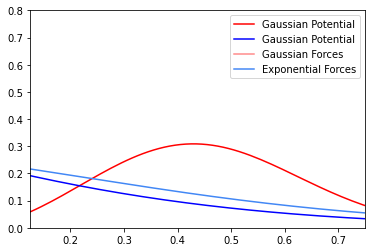

In [40]:
A = MATRIX(1, 2)
start = -5
steps = 1000
b = .5
dim = 1
x2 = np.linspace(-start, start, steps)
GaussianPotentials = np.zeros(len(x2))
GaussianForces = np.zeros(len(x2))
ExponentialPotentials = np.zeros(len(x2))
ExponentialForces = np.zeros(len(x2))

for i in range(len(x2)):
    A.set(0, 1, x2[i])
    Fg, Ug = gaussian_kernel(A, dim, b)
    Fe, Ue = exponential_kernel(A, dim, b)
    GaussianPotentials[i] = Ug
    GaussianForces[i] = Fg.get(0, 1)
    ExponentialPotentials[i] = exponential_kernel(A, dim, b)[1]
    ExponentialForces[i] = Fe.get(0, 1)
    
    

# plt.xlim( (-2, 2) )
# plt.ylim(-.35, .35)
plt.xlim(.125, .75)
plt.ylim(0, .8)
plt.plot(x2, GaussianPotentials, label = "Gaussian Potential", color = "red")
plt.plot(x2, ExponentialPotentials, label = "Gaussian Potential", color = "blue")
plt.plot(x2, GaussianForces/(4*max(GaussianForces)), label = "Gaussian Forces", color = '#ff8a8a')
plt.plot(x2, ExponentialForces/(4*max(ExponentialForces)), label = "Exponential Forces", color = '#4287f5')
plt.legend()




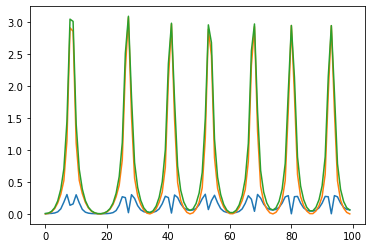

In [158]:
A = MATRIX(1, 2)
A.set(0, 0, 1)
A.set(0, 1, 0)
b=.5
steps = 100
dt = .1

filename = "Default.xyz"
try:
    os.remove(filename)
except:
    pass

MIW, T = Verlet(A, b, steps, dt, filename = "Default.xyz") 


xs = np.arange(steps)
plt.figure(2)
plt.plot(xs, MIW)
plt.plot(xs, T)
plt.plot(xs, T+MIW)

In [44]:
X = MATRIX(4, 4)
X.set(1, 1, 1)
Anp = ConvertMatrix(X)

print(X.get(1, 1))
print(Anp[1][1])
print(Anp)


1.0
1.0
[[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [16]:
help(MATRIX)

Help on class MATRIX in module liblibra_core:

class MATRIX(base_matrix_general)
 |  Method resolution order:
 |      MATRIX
 |      base_matrix_general
 |      Boost.Python.instance
 |      builtins.object
 |  
 |  Static methods defined here:
 |  
 |  FindMaxNondiagonalElement(...)
 |      FindMaxNondiagonalElement( (MATRIX)arg1, (int)arg2, (int)arg3, (float)arg4) -> None :
 |      
 |          C++ signature :
 |              void FindMaxNondiagonalElement(liblibra::liblinalg::MATRIX {lvalue},int {lvalue},int {lvalue},double {lvalue})
 |  
 |  Init(...)
 |      Init( (MATRIX)arg1, (float)arg2) -> None :
 |      
 |          C++ signature :
 |              void Init(liblibra::liblinalg::MATRIX {lvalue},double)
 |  
 |  InitSquareMatrix(...)
 |      InitSquareMatrix( (MATRIX)arg1, (int)arg2, (float)arg3) -> None :
 |      
 |          C++ signature :
 |              void InitSquareMatrix(liblibra::liblinalg::MATRIX {lvalue},int,double)
 |  
 |  Init_Unit_Matrix(...)
 |      Init_Unit_M